In [102]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
import datetime,os
import pandas as pd
from fuzzywuzzy import fuzz
import pyodbc
import re
from itertools import product

# Read in STR table
def read_STR(dbpath):
    # Connect to Access DB
    conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ='+dbpath+';')
    # Read Single Transactions table
    STR = pd.read_sql_query(
    '''
    SELECT * FROM STR
    '''
    ,conn).reset_index(drop=True)
    # Close connection
    conn.close()
    # Transform STR
    STR['Date_booked'] = pd.to_datetime(STR['Date_booked'])
    STR['Date_ordered'] = pd.to_datetime(STR['Date_ordered'])
    STR['Value_transaction'] = STR['Value_transaction'].astype('float')
    return STR
# Read in TRI table
def read_TRI(dbpath):
    # Connect to Access DB
    conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ='+dbpath+';')
    # Read Transaction Information table
    TRI = pd.read_sql_query(
    '''
    SELECT * FROM TRINFORMATION
    '''
    ,conn).reset_index(drop=True)
    # Close connection
    conn.close()
    return TRI

# Path definitions
dbpath = '..\\..\\..\\..\\banking.accdb'
# Read existing databases
STR = read_STR(dbpath)
TRI = read_TRI(dbpath)

# Extract relevant information
df = STR[['Date_booked','Value_transaction']]
df = df.drop(index=df[df['Value_transaction']>=0].index).reset_index(drop=True)
# Generate interesting time indices
df['YYYY-MM'] = pd.to_datetime(df['Date_booked'].apply(lambda x: x.strftime('%m-%Y')))
df['YYYY-MM-DD'] = pd.to_datetime(df['Date_booked'].apply(lambda x: x.strftime('%d-%m-%Y')))
# Extract single date identifiers
df['DD'] = df['Date_booked'].apply(lambda x: x.day)
df['MM'] = df['Date_booked'].apply(lambda x: x.month)
df['YYYY'] = df['Date_booked'].apply(lambda x: x.year)
# Drop unformatted column
df = df.drop(columns=['Date_booked'])

# Accumulate by months and days 
rf_monthly = df[['YYYY-MM','Value_transaction']].groupby(['YYYY-MM']).sum().abs()
rf_daily = df[['YYYY-MM-DD','Value_transaction']].groupby(['YYYY-MM-DD']).sum().abs()
# Extract full date
rf_monthly['Date'] = rf_monthly.apply(lambda x: x.index)
rf_daily['Date'] = rf_daily.apply(lambda x: x.index)
# Extract years
rf_daily['Year'] = rf_daily.apply(lambda x: x['Date'].year,axis=1)
rf_monthly['Year'] = rf_monthly.apply(lambda x: x['Date'].year,axis=1)
# Extract months
rf_daily['Month'] = rf_daily.apply(lambda x: x['Date'].month,axis=1)
rf_monthly['Month'] = rf_monthly.apply(lambda x: x['Date'].month,axis=1)
# Extract days
rf_daily['Day'] = rf_daily.apply(lambda x: x['Date'].day,axis=1)
rf_monthly['Day'] = rf_monthly.apply(lambda x: x['Date'].day,axis=1)

# Determine current dates of interest
c_date = df['YYYY-MM-DD'].max()
p_date = c_date-pd.DateOffset(months=1)
pp_date = c_date-pd.DateOffset(months=2)
ppp_date = c_date-pd.DateOffset(months=3)
# Current month
start_date = '{}-{}-{}'.format(str(c_date.year),str(str(c_date.month).zfill(2)),'01')
end_date = '{}-{}-{}'.format(str(c_date.year if c_date.month!=12 else c_date.year+1),str(str((c_date.month)%12+1).zfill(2)),'01')
c_index = pd.date_range(
    start=start_date,
    end=end_date
)[:-1]
tf = rf_daily[(rf_daily['Year']==c_date.year)&(rf_daily['Month']==c_date.month)][['Value_transaction']]
m0 = tf.reindex(c_index,fill_value=0)
# Current month - 1
start_date = '{}-{}-{}'.format(str(p_date.year),str(str(p_date.month).zfill(2)),'01')
end_date = '{}-{}-{}'.format(str(p_date.year if p_date.month!=12 else p_date.year+1),str(str((p_date.month)%12+1).zfill(2)),'01')
c_index = pd.date_range(
    start=start_date,
    end=end_date
)[:-1]
tf = rf_daily[(rf_daily['Year']==p_date.year)&(rf_daily['Month']==p_date.month)][['Value_transaction']]
m1 = tf.reindex(c_index,fill_value=0)
# Current month - 2
start_date = '{}-{}-{}'.format(str(pp_date.year),str(str(pp_date.month).zfill(2)),'01')
end_date = '{}-{}-{}'.format(str(pp_date.year if pp_date.month!=12 else pp_date.year+1),str(str((pp_date.month)%12+1).zfill(2)),'01')
c_index = pd.date_range(
    start=start_date,
    end=end_date
)[:-1]
tf = rf_daily[(rf_daily['Year']==pp_date.year)&(rf_daily['Month']==pp_date.month)][['Value_transaction']]
m2 = tf.reindex(c_index,fill_value=0)
# Current month - 3
start_date = '{}-{}-{}'.format(str(ppp_date.year),str(str(ppp_date.month).zfill(2)),'01')
end_date = '{}-{}-{}'.format(str(ppp_date.year if ppp_date.month!=12 else ppp_date.year+1),str(str((ppp_date.month)%12+1).zfill(2)),'01')
c_index = pd.date_range(
    start=start_date,
    end=end_date
)[:-1]
tf = rf_daily[(rf_daily['Year']==ppp_date.year)&(rf_daily['Month']==ppp_date.month)][['Value_transaction']]
m3 = tf.reindex(c_index,fill_value=0)

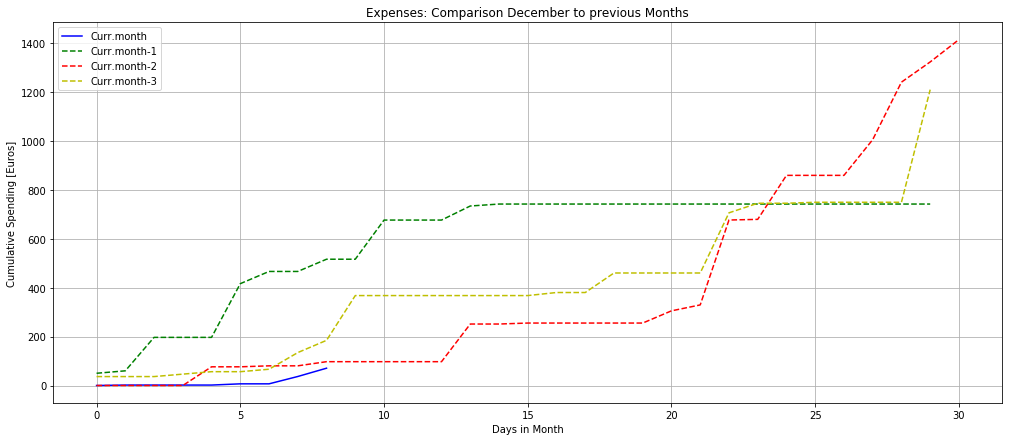

In [110]:
# Plot cumulative spending throughout latest months
fig = plt.figure(figsize=(17,7))

plt.plot(m0[:c_date.day].cumsum().values,'b')
plt.plot(m1.cumsum().values,'g--')
plt.plot(m2.cumsum().values,'r--')
plt.plot(m3.cumsum().values,'y--')

plt.xlabel('Days in Month')
plt.ylabel('Cumulative Spending [Euros]')
plt.title('Expenses: Comparison {} to previous Months'.format(c_date.month_name()))

plt.legend(['Curr.month','Curr.month-1','Curr.month-2','Curr.month-3'])
plt.grid()

plt.show()

In [128]:
bf = STR[['Date_booked','Value_transaction']]

pf = bf[bf['Value_transaction']>0].reset_index(drop=True)
nf = bf[bf['Value_transaction']<0].reset_index(drop=True)

pf['YYYY-MM'] = pd.to_datetime(pf['Date_booked'].apply(lambda x: x.strftime('%m-%Y')))
nf['YYYY-MM'] = pd.to_datetime(nf['Date_booked'].apply(lambda x: x.strftime('%m-%Y')))

pf = pf.drop(columns=['Date_booked'])
nf = nf.drop(columns=['Date_booked'])

In [131]:
pf = pf.groupby(['YYYY-MM']).sum()
nf = nf.groupby(['YYYY-MM']).sum()

In [142]:
mf = pd.merge(nf,pf,on='YYYY-MM').rename(columns={
    'Value_transaction_x':'expenses',
    'Value_transaction_y':'revenue'
})
mf['expenses'] = mf['expenses'].abs()

In [143]:
mf

,expenses,revenue
YYYY-MM,,
2018-11-01,1646.94,870.00
2018-12-01,1228.02,1250.00
2019-01-01,1744.20,1342.50
2019-02-01,1258.46,1335.00
2019-03-01,1075.29,1185.00
2019-04-01,1749.93,530.50
2019-05-01,1429.75,2706.06
2019-06-01,1032.59,2685.77
2019-07-01,1644.53,2485.77


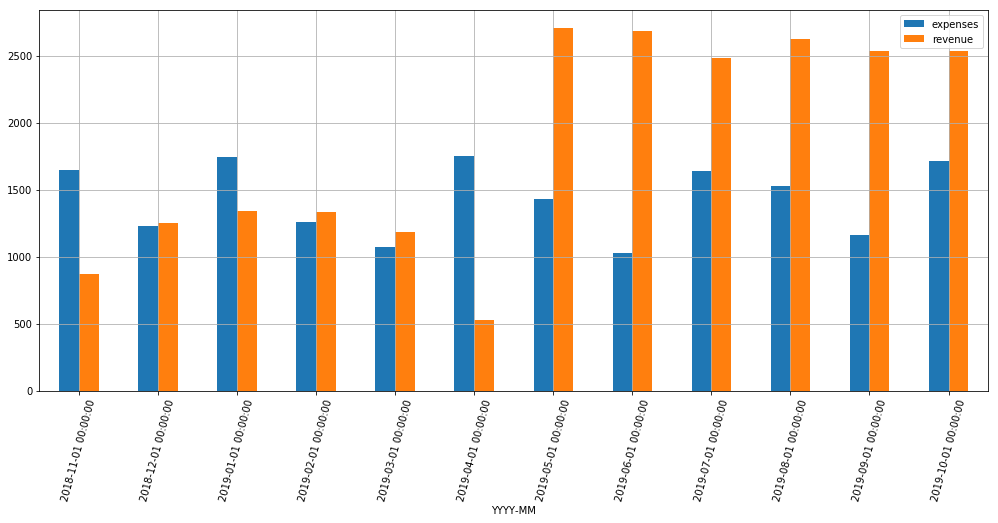

In [156]:
mf.plot(kind='bar',rot=75,figsize=(17,7),grid=True,)